In [3]:
import pandas as pd
import numpy as np
import nltk
import string
import fasttext
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
plt.xticks(rotation=70)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)
%matplotlib inline

In [ ]:
!pip install fasttext

In [ ]:
!pip install contractions
!pip install swifter

In [5]:
submissions = "/content/drive/MyDrive/stocks/stocks_submissions_features_tickers.csv"
df_submissions = pd.read_csv(submissions, delimiter=";")
df_submissions.head()

,created_utc,author,created_utc.1,id,link_flair_text,num_comments,score,subreddit_subscribers,selftext,title,upvote_ratio,title_polarity,title_subjectivity,body_polarity,body_subjectivity,polarity,title_tokens,selftext_tokens,tickers
0,2021-11-26 13:19:32,NovelAnteater,2021-11-26 13:19:32,r2nb9a,NaN,0,1,3310630,[removed],SNAP seems like a great long-term buy at this price.,1.0,0.800000,0.750000,0.000000,0.000000,0.800000,"['SNAP', 'seems', 'like', 'a', 'great', 'long', '-', 'term', 'buy', 'at', 'this', 'price', '.']","['[', 'removed', ']']",['SNAP']
1,2021-11-26 12:37:50,VonDerBerg,2021-11-26 12:37:50,r2ma8u,Trades,0,1,3310546,So the markets are tanking on new variant news. $NVAX just might save the day with protein based...,$NVAX new variant,1.0,0.136364,0.454545,0.094084,0.514141,0.230447,"['$', 'NVAX', 'new', 'variant']","['So', 'the', 'markets', 'are', 'tanking', 'on', 'new', 'variant', 'news', '.', '$', 'NVAX', 'ju...","['WE', 'NOW', 'NVAX', 'YOU', 'AN', 'FOR', 'UK', 'ARE']"
2,2021-11-26 12:36:24,VonDerBerg,2021-11-26 12:36:24,r2m96j,Trades,0,1,3310543,[removed],$NVAX new variant,1.0,0.136364,0.454545,0.000000,0.000000,0.136364,"['$', 'NVAX', 'new', 'variant']","['[', 'removed', ']']",['NVAX']
3,2021-11-26 12:29:36,VonDerBerg,2021-11-26 12:29:36,r2m3di,Trades,0,1,3310525,[removed],$NVAX lift-off confirmed,1.0,0.400000,1.000000,0.000000,0.000000,0.400000,"['$', 'NVAX', 'lift', '-', 'off', 'confirmed']","['[', 'removed', ']']",['NVAX']
4,2021-11-26 12:10:01,ghdsvor,2021-11-26 12:10:01,r2lrdw,Advice Request,0,1,3310479,[removed],Where to find dates that annual reports were published?,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,"['Where', 'to', 'find', 'dates', 'that', 'annual', 'reports', 'were', 'published', '?']","['[', 'removed', ']']",NaN


In [6]:
df_submissions.index = pd.DatetimeIndex(df_submissions.created_utc)
# drop duplicate columns
df_submissions.drop('created_utc.1', axis=1, inplace=True)
df_submissions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 154506 entries, 2021-11-26 13:19:32 to 2018-12-30 00:26:31
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   created_utc            154506 non-null  object 
 1   author                 154506 non-null  object 
 2   id                     154506 non-null  object 
 3   link_flair_text        67947 non-null   object 
 4   num_comments           154506 non-null  int64  
 5   score                  154506 non-null  int64  
 6   subreddit_subscribers  154506 non-null  int64  
 7   selftext               132641 non-null  object 
 8   title                  154506 non-null  object 
 9   upvote_ratio           154506 non-null  float64
 10  title_polarity         154506 non-null  float64
 11  title_subjectivity     154506 non-null  float64
 12  body_polarity          154506 non-null  float64
 13  body_subjectivity      154506 non-null  float64
 14  po

In [28]:
df_NLP = df_submissions.loc[:,['id','title','selftext']]
df_NLP.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 154506 entries, 2021-11-26 13:19:32 to 2018-12-30 00:26:31
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        154506 non-null  object
 1   title     154506 non-null  object
 2   selftext  132641 non-null  object
dtypes: object(3)
memory usage: 4.7+ MB


## 1. Text Pre-Processing

In [29]:
for col in df_NLP.columns:
    print(col, df_NLP[col].isnull().sum())

id 0
title 0
selftext 21865


In [30]:
df_NLP['selftext'] = df_NLP['selftext'].fillna("")
df_NLP['selftext'] = df_NLP['selftext'].astype(str)

## 1.1 Expanding Contractions

In [31]:
df_NLP['title_no_contract'] = df_NLP['title'].apply(lambda x: [contractions.fix(word) for word in x.split()])
df_NLP['selftext_no_contract'] = df_NLP['selftext'].apply(lambda x: [contractions.fix(word) for word in x.split()])

In [32]:
df_NLP.head(10)

,id,title,selftext,title_no_contract,selftext_no_contract
created_utc,,,,,
2021-11-26 13:19:32,r2nb9a,SNAP seems like a great long-term buy at this price.,[removed],"[SNAP, seems, like, a, great, long-term, buy, at, this, price.]",[[removed]]
2021-11-26 12:37:50,r2ma8u,$NVAX new variant,So the markets are tanking on new variant news. $NVAX just might save the day with protein based...,"[$NVAX, new, variant]","[So, the, markets, are, tanking, on, new, variant, news., $NVAX, just, might, save, the, day, wi..."
2021-11-26 12:36:24,r2m96j,$NVAX new variant,[removed],"[$NVAX, new, variant]",[[removed]]
2021-11-26 12:29:36,r2m3di,$NVAX lift-off confirmed,[removed],"[$NVAX, lift-off, confirmed]",[[removed]]
2021-11-26 12:10:01,r2lrdw,Where to find dates that annual reports were published?,[removed],"[Where, to, find, dates, that, annual, reports, were, published?]",[[removed]]
2021-11-26 12:07:40,r2lpz7,Be greedy when others are fearful. Be fearful when others are greedy.,Looks like all of the markets are going to take a shit on the news of the new Covid variant. Fun...,"[Be, greedy, when, others, are, fearful., Be, fearful, when, others, are, greedy.]","[Looks, like, all, of, the, markets, are, going, to, take, a, shit, on, the, news, of, the, new,..."
2021-11-26 12:04:57,r2loi2,Nasdaq Tech companies and inflation,"As many of you know, a lot of nasdaq companies are very well valuated. With inflation coming, ne...","[Nasdaq, Tech, companies, and, inflation]","[As, many, of, you, know,, a, lot, of, nasdaq, companies, are, very, well, valuated., With, infl..."
2021-11-26 12:00:12,r2lli5,"r/Stocks Daily Thread on Meme Stocks Friday - Nov 26, 2021",The meme stock scheduled posts will run Mon to Fri and won't be a sticky; you're probably seeing...,"[r/Stocks, Daily, Thread, on, Meme, Stocks, Friday, -, Nov, 26,, 2021]","[The, meme, stock, scheduled, posts, will, run, Mon, to, Fri, and, will not, be, a, sticky;, you..."
2021-11-26 11:39:51,r2lal9,How can an individual short stocks?,[removed],"[How, can, an, individual, short, stocks?]",[[removed]]


In [33]:
# turn no contract columns back into strings
df_NLP['title_str'] = [' '.join(map(str, l)) for l in df_NLP['title_no_contract']]
df_NLP['selfttext_str'] = [' '.join(map(str, l)) for l in df_NLP['selftext_no_contract']]

In [34]:
df_NLP.head(10)

,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str
created_utc,,,,,,,
2021-11-26 13:19:32,r2nb9a,SNAP seems like a great long-term buy at this price.,[removed],"[SNAP, seems, like, a, great, long-term, buy, at, this, price.]",[[removed]],SNAP seems like a great long-term buy at this price.,[removed]
2021-11-26 12:37:50,r2ma8u,$NVAX new variant,So the markets are tanking on new variant news. $NVAX just might save the day with protein based...,"[$NVAX, new, variant]","[So, the, markets, are, tanking, on, new, variant, news., $NVAX, just, might, save, the, day, wi...",$NVAX new variant,So the markets are tanking on new variant news. $NVAX just might save the day with protein based...
2021-11-26 12:36:24,r2m96j,$NVAX new variant,[removed],"[$NVAX, new, variant]",[[removed]],$NVAX new variant,[removed]
2021-11-26 12:29:36,r2m3di,$NVAX lift-off confirmed,[removed],"[$NVAX, lift-off, confirmed]",[[removed]],$NVAX lift-off confirmed,[removed]
2021-11-26 12:10:01,r2lrdw,Where to find dates that annual reports were published?,[removed],"[Where, to, find, dates, that, annual, reports, were, published?]",[[removed]],Where to find dates that annual reports were published?,[removed]
2021-11-26 12:07:40,r2lpz7,Be greedy when others are fearful. Be fearful when others are greedy.,Looks like all of the markets are going to take a shit on the news of the new Covid variant. Fun...,"[Be, greedy, when, others, are, fearful., Be, fearful, when, others, are, greedy.]","[Looks, like, all, of, the, markets, are, going, to, take, a, shit, on, the, news, of, the, new,...",Be greedy when others are fearful. Be fearful when others are greedy.,Looks like all of the markets are going to take a shit on the news of the new Covid variant. Fun...
2021-11-26 12:04:57,r2loi2,Nasdaq Tech companies and inflation,"As many of you know, a lot of nasdaq companies are very well valuated. With inflation coming, ne...","[Nasdaq, Tech, companies, and, inflation]","[As, many, of, you, know,, a, lot, of, nasdaq, companies, are, very, well, valuated., With, infl...",Nasdaq Tech companies and inflation,"As many of you know, a lot of nasdaq companies are very well valuated. With inflation coming, ne..."
2021-11-26 12:00:12,r2lli5,"r/Stocks Daily Thread on Meme Stocks Friday - Nov 26, 2021",The meme stock scheduled posts will run Mon to Fri and won't be a sticky; you're probably seeing...,"[r/Stocks, Daily, Thread, on, Meme, Stocks, Friday, -, Nov, 26,, 2021]","[The, meme, stock, scheduled, posts, will, run, Mon, to, Fri, and, will not, be, a, sticky;, you...","r/Stocks Daily Thread on Meme Stocks Friday - Nov 26, 2021",The meme stock scheduled posts will run Mon to Fri and will not be a sticky; you are probably se...
2021-11-26 11:39:51,r2lal9,How can an individual short stocks?,[removed],"[How, can, an, individual, short, stocks?]",[[removed]],How can an individual short stocks?,[removed]


## 1.2 English Language Detection

In [35]:
pretrained_model = "/content/drive/MyDrive/WSB/lid.176.bin" 
model = fasttext.load_model(pretrained_model)
langs = []
for sent in df_NLP['selfttext_str']:
    lang = model.predict(sent)[0]
    langs.append(str(lang)[11:13])
df_NLP['langs'] = langs

In [36]:
df_NLP['langs'].unique()

array(['go', 'en', 'fr', 'pl', 'de', 'ta', 'ja', 'ru', 'hu', 'da', 'sv',
       'ur', 'es', 'tr', 'uz', 'eo', 'ca', 'la', 'be', 'hy', 'it', 'uk',
       'km', 'lb', 'zh'], dtype=object)

In [37]:
df_langs = df_NLP.groupby("langs")["langs"].count().sort_values(ascending=False)
print(f"{len(df_langs)} languages:\n{df_langs.index.values}\n")
print(f"Top 15 languages count:\n{df_langs.head(87)}")

25 languages:
['en' 'go' 'fr' 'de' 'es' 'ja' 'ru' 'pl' 'hu' 'ca' 'tr' 'la' 'it' 'da'
 'eo' 'zh' 'hy' 'uz' 'km' 'lb' 'sv' 'ta' 'uk' 'ur' 'be']

Top 15 languages count:
langs
en    81295
go    73155
fr        9
de        8
es        6
ja        4
ru        4
pl        3
hu        2
ca        2
tr        2
la        2
it        2
da        1
eo        1
zh        1
hy        1
uz        1
km        1
lb        1
sv        1
ta        1
uk        1
ur        1
be        1
Name: langs, dtype: int64


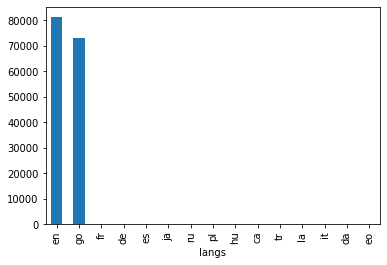

In [38]:
df_langs.head(15).plot.bar()

In [39]:
df_NLP[df_NLP['langs'] == 'ja']

,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs
created_utc,,,,,,,,
2021-08-05 14:57:25,oyk3j5,CTRM TO THE MOON🚀🌕,THIS STOCK IS READY FOR LIFTOFF SO HOP ON!!,"[CTRM, TO, THE, MOON🚀🌕]","[THIS, STOCK, IS, READY, FOR, LIFTOFF, SO, HOP, ON!!]",CTRM TO THE MOON🚀🌕,THIS STOCK IS READY FOR LIFTOFF SO HOP ON!!,ja
2021-01-28 13:11:02,l6w72b,AAL STOCK,AAL IS NEW GME?,"[AAL, STOCK]","[AAL, IS, NEW, GME?]",AAL STOCK,AAL IS NEW GME?,ja
2021-01-28 13:10:12,l6w6ii,DOGE !!!,Let's go EVERYONE!! #DOGE,"[DOGE, !!!]","[let us, go, EVERYONE!!, #DOGE]",DOGE !!!,let us go EVERYONE!! #DOGE,ja
2021-01-27 16:08:18,l67q07,BOXL,BOXL,[BOXL],[BOXL],BOXL,BOXL,ja


### It can be seen that even though selftext of some submissions was classified as japanese langauge it is not the case.

In [40]:
df_NLP[df_NLP['langs'] == 'zh']

,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs
created_utc,,,,,,,,
2019-07-05 11:33:53,c9exdk,This Discord has $400k gain record from secret alerts. Come follow their alerts and be gainer,Check @ [http://teyreg.gq](http://teyreg.gq),"[This, Discord, has, $400k, gain, record, from, secret, alerts., Come, follow, their, alerts, an...","[Check, @, [http://teyreg.gq](http://teyreg.gq)]",This Discord has $400k gain record from secret alerts. Come follow their alerts and be gainer,Check @ [http://teyreg.gq](http://teyreg.gq),zh


In [41]:
df_NLP[df_NLP['langs'] == 'fr']

,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs
created_utc,,,,,,,,
2021-11-22 02:08:33,qzafj3,Rock &amp; Roll in the market,🚚$$$$$&amp;$$$$$$,"[Rock, &amp;, Roll, in, the, market]",[🚚$$$$$&amp;$$$$$$],Rock &amp; Roll in the market,🚚$$$$$&amp;$$$$$$,fr
2021-04-28 11:43:02,n0cxbh,Stock PLTR: Palantir prêt à fournir des rendements stables à long terme,https://www.marseillenews.net/stock-pltr-palantir-pret-a-fournir-des-rendements-stables-a-long-t...,"[Stock, PLTR:, Palantir, prêt, à, fournir, des, rendements, stables, à, long, terme]",[https://www.marseillenews.net/stock-pltr-palantir-pret-a-fournir-des-rendements-stables-a-long-...,Stock PLTR: Palantir prêt à fournir des rendements stables à long terme,https://www.marseillenews.net/stock-pltr-palantir-pret-a-fournir-des-rendements-stables-a-long-t...,fr
2021-01-28 13:47:34,l6wzsy,DOES SOMEBODY KNOW A GOOD TRADING APP. ROBINHOOD IS NOT AVAILABLE IN MY COUNTRY (NETHERLANDS),.,"[DOES, SOMEBODY, KNOW, A, GOOD, TRADING, APP., ROBINHOOD, IS, NOT, AVAILABLE, IN, MY, COUNTRY, (...",[.],DOES SOMEBODY KNOW A GOOD TRADING APP. ROBINHOOD IS NOT AVAILABLE IN MY COUNTRY (NETHERLANDS),.,fr
2021-01-28 13:32:22,l6wnbo,"This is a pretty low effort post... but after I invested in Shopify about 4 years ago, I have so...",.,"[This, is, a, pretty, low, effort, post..., but, after, I, invested, in, Shopify, about, 4, year...",[.],"This is a pretty low effort post... but after I invested in Shopify about 4 years ago, I have so...",.,fr
2021-01-27 17:13:13,l69azg,My winning portfolio,"FUTU, DQ, LOGI, REGI, PBW, SITM, PINS","[My, winning, portfolio]","[FUTU,, DQ,, LOGI,, REGI,, PBW,, SITM,, PINS]",My winning portfolio,"FUTU, DQ, LOGI, REGI, PBW, SITM, PINS",fr
2021-01-09 06:43:41,ktlv59,"Les Français, quelle application utilisez-vous pour investir en bourse ?","Salut,\n\nJe voudrais que ma sœur commence à investir en bourse mais je ne sais pas quel est le ...","[Les, Français,, quelle, application, utilisez-vous, pour, investir, en, bourse, ?]","[Salut,, Je, voudrais, que, ma, sœur, commence, à, investir, en, bourse, mais, je, ne, sais, pas...","Les Français, quelle application utilisez-vous pour investir en bourse ?","Salut, Je voudrais que ma sœur commence à investir en bourse mais je ne sais pas quel est le bon...",fr
2020-12-08 17:50:59,k990in,hey where should i invest?,.,"[hey, where, should, i, invest?]",[.],hey where should i invest?,.,fr
2020-05-12 11:22:57,gi9cp7,WHY IS THE STOCK MARKET RISING? AND SHOULD YOU WORRY ABOUT IT?,[https://youtu.be/POY3fKW6ZF8](https://youtu.be/POY3fKW6ZF8),"[WHY, IS, THE, STOCK, MARKET, RISING?, AND, SHOULD, YOU, WORRY, ABOUT, IT?]",[[https://youtu.be/POY3fKW6ZF8](https://youtu.be/POY3fKW6ZF8)],WHY IS THE STOCK MARKET RISING? AND SHOULD YOU WORRY ABOUT IT?,[https://youtu.be/POY3fKW6ZF8](https://youtu.be/POY3fKW6ZF8),fr
2020-04-06 08:37:20,fvv4tj,Whats the most y’all have made in a day,.,"[what is, the, most, you all, have, made, in, a, day]",[.],what is the most you all have made in a day,.,fr


In [42]:
df_NLP[df_NLP['langs'] == 'de']

,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs
created_utc,,,,,,,,
2021-08-18 22:42:17,p723bm,Modern plant based foods,Ich finde dieses Unternehmen toll! Bin selber vegan und seit ein paar Monaten investiert - das e...,"[Modern, plant, based, foods]","[Ich, finde, dieses, Unternehmen, toll!, Bin, selber, vegan, und, seit, ein, paar, Monaten, inve...",Modern plant based foods,Ich finde dieses Unternehmen toll! Bin selber vegan und seit ein paar Monaten investiert - das e...,de
2021-01-28 14:11:17,l6xjt9,Trade Republic is Open,"Ich bin begeistert von Trade Republic, Europas mobilem und provisionsfreiem Broker. \nMelde Dich...","[Trade, Republic, is, Open]","[Ich, bin, begeistert, von, Trade, Republic,, Europas, mobilem, und, provisionsfreiem, Broker., ...",Trade Republic is Open,"Ich bin begeistert von Trade Republic, Europas mobilem und provisionsfreiem Broker. Melde Dich j...",de
2021-01-28 12:54:34,l6vvm9,Everyone buy Nokia!!!,Nok nok!!!!,"[Everyone, buy, Nokia!!!]","[Nok, nok!!!!]",Everyone buy Nokia!!!,Nok nok!!!!,de
2021-01-04 20:19:21,kqgxvm,"German Question: EAEG Gesetzt, welches Vermögen ist geschützt?","Hallo,\n\nich habe eine Frage bezüglich der Einlagensicherung.\n\nIch weiß das 100k als Sonderve...","[German, Question:, EAEG, Gesetzt,, welches, Vermögen, ist, geschützt?]","[Hallo,, ich, habe, eine, Frage, bezüglich, der, Einlagensicherung., Ich, weiß, das, 100k, als, ...","German Question: EAEG Gesetzt, welches Vermögen ist geschützt?","Hallo, ich habe eine Frage bezüglich der Einlagensicherung. Ich weiß das 100k als Sondervermögen...",de
2020-08-28 19:37:58,iidw8c,Why is BETZ up 6% when DKNG is down 6%?,What is going on? thanks\n\n&amp;#x200B;\n\n&amp;#x200B;\n\n&amp;#x200B;\n\nText Text Text Text ...,"[Why, is, BETZ, up, 6%, when, DKNG, is, down, 6%?]","[What, is, going, on?, thanks, &amp;#x200B;, &amp;#x200B;, &amp;#x200B;, Text, Text, Text, Text,...",Why is BETZ up 6% when DKNG is down 6%?,What is going on? thanks &amp;#x200B; &amp;#x200B; &amp;#x200B; Text Text Text Text Text Text Te...,de
2020-05-20 17:54:06,gng774,Lufthansa (LHA) to receive 9bn by German government in exchange of 25% of the company,Article in German:\n\nhttps://www.google.com/amp/s/amp.n-tv.de/wirtschaft/Rettungspaket-fuer-die...,"[Lufthansa, (LHA), to, receive, 9bn, by, German, government, in, exchange, of, 25%, of, the, com...","[Article, in, German:, https://www.google.com/amp/s/amp.n-tv.de/wirtschaft/Rettungspaket-fuer-di...",Lufthansa (LHA) to receive 9bn by German government in exchange of 25% of the company,Article in German: https://www.google.com/amp/s/amp.n-tv.de/wirtschaft/Rettungspaket-fuer-die-Lu...,de
2020-05-11 10:08:18,ghku4r,Lufthansa increases flight destinations from 30 to 106 due to increased interest in holidays abroad,Looks like it's picking up faster than expected for now...\n\nhttps://www.google.com/amp/s/amp.w...,"[Lufthansa, increases, flight, destinations, from, 30, to, 106, due, to, increased, interest, in...","[Looks, like, it is, picking, up, faster, than, expected, for, now..., https://www.google.com/am...",Lufthansa increases flight destinations from 30 to 106 due to increased interest in holidays abroad,Looks like it is picking up faster than expected for now... https://www.google.com/amp/s/amp.wel...,de
2020-03-17 14:11:16,fk5w8o,Sell like no other boys and girls. Buy put options $GILD,Lmk,"[Sell, like, no, other, boys, and, girls., Buy, put, options, $GILD]",[Lmk],Sell like no other boys and girls. Buy put options $GILD,Lmk,de


In [43]:
# remove non english submissions 
df_NLP = df_NLP[(df_NLP['langs'] == 'en') | (df_NLP['langs'] == 'go')]

## 1.3 Converting all Characters to Lowercase, Tokenization, Removing Punctuations

In [44]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [45]:
df_NLP['title_tokenized'] = df_NLP['title_str'].apply(word_tokenize)
df_NLP['selftext_tokenized'] = df_NLP['selfttext_str'].apply(word_tokenize)


In [46]:
punc = string.punctuation
df_NLP['title_tokenized']  = df_NLP['title_tokenized'].apply(lambda x: [word.lower() for word in x])
df_NLP['title_tokenized']  = df_NLP['title_tokenized'].apply(lambda x: [word for word in x if word not in punc])
df_NLP['selftext_tokenized'] = df_NLP['selftext_tokenized'].apply(lambda x: [word.lower() for word in x])
df_NLP['selftext_tokenized'] = df_NLP['selftext_tokenized'].apply(lambda x: [word for word in x if word not in punc])

In [47]:
df_NLP.head()

,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs,title_tokenized,selftext_tokenized
created_utc,,,,,,,,,,
2021-11-26 13:19:32,r2nb9a,SNAP seems like a great long-term buy at this price.,[removed],"[SNAP, seems, like, a, great, long-term, buy, at, this, price.]",[[removed]],SNAP seems like a great long-term buy at this price.,[removed],go,"[snap, seems, like, a, great, long-term, buy, at, this, price]",[removed]
2021-11-26 12:37:50,r2ma8u,$NVAX new variant,So the markets are tanking on new variant news. $NVAX just might save the day with protein based...,"[$NVAX, new, variant]","[So, the, markets, are, tanking, on, new, variant, news., $NVAX, just, might, save, the, day, wi...",$NVAX new variant,So the markets are tanking on new variant news. $NVAX just might save the day with protein based...,en,"[nvax, new, variant]","[so, the, markets, are, tanking, on, new, variant, news, nvax, just, might, save, the, day, with..."
2021-11-26 12:36:24,r2m96j,$NVAX new variant,[removed],"[$NVAX, new, variant]",[[removed]],$NVAX new variant,[removed],go,"[nvax, new, variant]",[removed]
2021-11-26 12:29:36,r2m3di,$NVAX lift-off confirmed,[removed],"[$NVAX, lift-off, confirmed]",[[removed]],$NVAX lift-off confirmed,[removed],go,"[nvax, lift-off, confirmed]",[removed]
2021-11-26 12:10:01,r2lrdw,Where to find dates that annual reports were published?,[removed],"[Where, to, find, dates, that, annual, reports, were, published?]",[[removed]],Where to find dates that annual reports were published?,[removed],go,"[where, to, find, dates, that, annual, reports, were, published]",[removed]


## 1.4 Removing Stopwords 

In [48]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [49]:
stop_words = set(stopwords.words('english'))
df_NLP['title_tokenized'] = df_NLP['title_tokenized'].apply(lambda x: [word for word in x if word not in stop_words])
df_NLP['selftext_tokenized'] = df_NLP['selftext_tokenized'].apply(lambda x: [word for word in x if word not in stop_words])


In [50]:
df_NLP.head(10)

,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs,title_tokenized,selftext_tokenized
created_utc,,,,,,,,,,
2021-11-26 13:19:32,r2nb9a,SNAP seems like a great long-term buy at this price.,[removed],"[SNAP, seems, like, a, great, long-term, buy, at, this, price.]",[[removed]],SNAP seems like a great long-term buy at this price.,[removed],go,"[snap, seems, like, great, long-term, buy, price]",[removed]
2021-11-26 12:37:50,r2ma8u,$NVAX new variant,So the markets are tanking on new variant news. $NVAX just might save the day with protein based...,"[$NVAX, new, variant]","[So, the, markets, are, tanking, on, new, variant, news., $NVAX, just, might, save, the, day, wi...",$NVAX new variant,So the markets are tanking on new variant news. $NVAX just might save the day with protein based...,en,"[nvax, new, variant]","[markets, tanking, new, variant, news, nvax, might, save, day, protein, based, long, lasting, ef..."
2021-11-26 12:36:24,r2m96j,$NVAX new variant,[removed],"[$NVAX, new, variant]",[[removed]],$NVAX new variant,[removed],go,"[nvax, new, variant]",[removed]
2021-11-26 12:29:36,r2m3di,$NVAX lift-off confirmed,[removed],"[$NVAX, lift-off, confirmed]",[[removed]],$NVAX lift-off confirmed,[removed],go,"[nvax, lift-off, confirmed]",[removed]
2021-11-26 12:10:01,r2lrdw,Where to find dates that annual reports were published?,[removed],"[Where, to, find, dates, that, annual, reports, were, published?]",[[removed]],Where to find dates that annual reports were published?,[removed],go,"[find, dates, annual, reports, published]",[removed]
2021-11-26 12:07:40,r2lpz7,Be greedy when others are fearful. Be fearful when others are greedy.,Looks like all of the markets are going to take a shit on the news of the new Covid variant. Fun...,"[Be, greedy, when, others, are, fearful., Be, fearful, when, others, are, greedy.]","[Looks, like, all, of, the, markets, are, going, to, take, a, shit, on, the, news, of, the, new,...",Be greedy when others are fearful. Be fearful when others are greedy.,Looks like all of the markets are going to take a shit on the news of the new Covid variant. Fun...,en,"[greedy, others, fearful, fearful, others, greedy]","[looks, like, markets, going, take, shit, news, new, covid, variant, funny, thing, news, simply,..."
2021-11-26 12:04:57,r2loi2,Nasdaq Tech companies and inflation,"As many of you know, a lot of nasdaq companies are very well valuated. With inflation coming, ne...","[Nasdaq, Tech, companies, and, inflation]","[As, many, of, you, know,, a, lot, of, nasdaq, companies, are, very, well, valuated., With, infl...",Nasdaq Tech companies and inflation,"As many of you know, a lot of nasdaq companies are very well valuated. With inflation coming, ne...",en,"[nasdaq, tech, companies, inflation]","[many, know, lot, nasdaq, companies, well, valuated, inflation, coming, new, discounted, cash, f..."
2021-11-26 12:00:12,r2lli5,"r/Stocks Daily Thread on Meme Stocks Friday - Nov 26, 2021",The meme stock scheduled posts will run Mon to Fri and won't be a sticky; you're probably seeing...,"[r/Stocks, Daily, Thread, on, Meme, Stocks, Friday, -, Nov, 26,, 2021]","[The, meme, stock, scheduled, posts, will, run, Mon, to, Fri, and, will not, be, a, sticky;, you...","r/Stocks Daily Thread on Meme Stocks Friday - Nov 26, 2021",The meme stock scheduled posts will run Mon to Fri and will not be a sticky; you are probably se...,en,"[r/stocks, daily, thread, meme, stocks, friday, nov, 26, 2021]","[meme, stock, scheduled, posts, run, mon, fri, sticky, probably, seeing, automod, sent, woke, ea..."
2021-11-26 11:39:51,r2lal9,How can an individual short stocks?,[removed],"[How, can, an, individual, short, stocks?]",[[removed]],How can an individual short stocks?,[removed],go,"[individual, short, stocks]",[removed]


## 1.4 Lemmatization

In [51]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [52]:
df_NLP['pos_tags_title'] = df_NLP['title_tokenized'].apply(nltk.tag.pos_tag)
df_NLP['pos_tags_selftext'] = df_NLP['selftext_tokenized'].apply(nltk.tag.pos_tag)


In [53]:
%who_ls DataFrame 

['df_NLP', 'df_submissions']

In [54]:
df_NLP.head()

,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs,title_tokenized,selftext_tokenized,pos_tags_title,pos_tags_selftext
created_utc,,,,,,,,,,,,
2021-11-26 13:19:32,r2nb9a,SNAP seems like a great long-term buy at this price.,[removed],"[SNAP, seems, like, a, great, long-term, buy, at, this, price.]",[[removed]],SNAP seems like a great long-term buy at this price.,[removed],go,"[snap, seems, like, great, long-term, buy, price]",[removed],"[(snap, RB), (seems, VBZ), (like, IN), (great, JJ), (long-term, JJ), (buy, NN), (price, NN)]","[(removed, VBN)]"
2021-11-26 12:37:50,r2ma8u,$NVAX new variant,So the markets are tanking on new variant news. $NVAX just might save the day with protein based...,"[$NVAX, new, variant]","[So, the, markets, are, tanking, on, new, variant, news., $NVAX, just, might, save, the, day, wi...",$NVAX new variant,So the markets are tanking on new variant news. $NVAX just might save the day with protein based...,en,"[nvax, new, variant]","[markets, tanking, new, variant, news, nvax, might, save, day, protein, based, long, lasting, ef...","[(nvax, RB), (new, JJ), (variant, NN)]","[(markets, NNS), (tanking, VBG), (new, JJ), (variant, JJ), (news, NN), (nvax, NN), (might, MD), ..."
2021-11-26 12:36:24,r2m96j,$NVAX new variant,[removed],"[$NVAX, new, variant]",[[removed]],$NVAX new variant,[removed],go,"[nvax, new, variant]",[removed],"[(nvax, RB), (new, JJ), (variant, NN)]","[(removed, VBN)]"
2021-11-26 12:29:36,r2m3di,$NVAX lift-off confirmed,[removed],"[$NVAX, lift-off, confirmed]",[[removed]],$NVAX lift-off confirmed,[removed],go,"[nvax, lift-off, confirmed]",[removed],"[(nvax, JJ), (lift-off, NN), (confirmed, VBD)]","[(removed, VBN)]"
2021-11-26 12:10:01,r2lrdw,Where to find dates that annual reports were published?,[removed],"[Where, to, find, dates, that, annual, reports, were, published?]",[[removed]],Where to find dates that annual reports were published?,[removed],go,"[find, dates, annual, reports, published]",[removed],"[(find, VB), (dates, NNS), (annual, JJ), (reports, NNS), (published, VBD)]","[(removed, VBN)]"


In [55]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [56]:
d =[('menace', 'NN'), ('hedge', 'NN'), ('funds', 'NNS'), ('squeezing', 'VBG'), ('shorts', 'NNS')]
print(type(d))	
for index, tuple in enumerate(d):
    print(tuple[0], tuple[1])

for (word, pos_tag) in d:
    print(type((word, pos_tag)))
    print(word,pos_tag)
   

<class 'list'>
menace NN
hedge NN
funds NNS
squeezing VBG
shorts NNS
<class 'tuple'>
menace NN
<class 'tuple'>
hedge NN
<class 'tuple'>
funds NNS
<class 'tuple'>
squeezing VBG
<class 'tuple'>
shorts NNS


In [57]:
import json


In [60]:
def get_wordnet_pos(tag):    
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
df_NLP['title_wordnet_pos'] = df_NLP['pos_tags_title'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df_NLP['selftext_wordnet_pos'] = df_NLP['pos_tags_selftext'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df_NLP.head()

,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs,title_tokenized,selftext_tokenized,pos_tags_title,pos_tags_selftext,title_wordnet_pos,selftext_wordnet_pos
created_utc,,,,,,,,,,,,,,
2021-11-26 13:19:32,r2nb9a,SNAP seems like a great long-term buy at this price.,[removed],"[SNAP, seems, like, a, great, long-term, buy, at, this, price.]",[[removed]],SNAP seems like a great long-term buy at this price.,[removed],go,"[snap, seems, like, great, long-term, buy, price]",[removed],"[(snap, RB), (seems, VBZ), (like, IN), (great, JJ), (long-term, JJ), (buy, NN), (price, NN)]","[(removed, VBN)]","[(snap, r), (seems, v), (like, n), (great, a), (long-term, a), (buy, n), (price, n)]","[(removed, v)]"
2021-11-26 12:37:50,r2ma8u,$NVAX new variant,So the markets are tanking on new variant news. $NVAX just might save the day with protein based...,"[$NVAX, new, variant]","[So, the, markets, are, tanking, on, new, variant, news., $NVAX, just, might, save, the, day, wi...",$NVAX new variant,So the markets are tanking on new variant news. $NVAX just might save the day with protein based...,en,"[nvax, new, variant]","[markets, tanking, new, variant, news, nvax, might, save, day, protein, based, long, lasting, ef...","[(nvax, RB), (new, JJ), (variant, NN)]","[(markets, NNS), (tanking, VBG), (new, JJ), (variant, JJ), (news, NN), (nvax, NN), (might, MD), ...","[(nvax, r), (new, a), (variant, n)]","[(markets, n), (tanking, v), (new, a), (variant, a), (news, n), (nvax, n), (might, n), (save, v)..."
2021-11-26 12:36:24,r2m96j,$NVAX new variant,[removed],"[$NVAX, new, variant]",[[removed]],$NVAX new variant,[removed],go,"[nvax, new, variant]",[removed],"[(nvax, RB), (new, JJ), (variant, NN)]","[(removed, VBN)]","[(nvax, r), (new, a), (variant, n)]","[(removed, v)]"
2021-11-26 12:29:36,r2m3di,$NVAX lift-off confirmed,[removed],"[$NVAX, lift-off, confirmed]",[[removed]],$NVAX lift-off confirmed,[removed],go,"[nvax, lift-off, confirmed]",[removed],"[(nvax, JJ), (lift-off, NN), (confirmed, VBD)]","[(removed, VBN)]","[(nvax, a), (lift-off, n), (confirmed, v)]","[(removed, v)]"
2021-11-26 12:10:01,r2lrdw,Where to find dates that annual reports were published?,[removed],"[Where, to, find, dates, that, annual, reports, were, published?]",[[removed]],Where to find dates that annual reports were published?,[removed],go,"[find, dates, annual, reports, published]",[removed],"[(find, VB), (dates, NNS), (annual, JJ), (reports, NNS), (published, VBD)]","[(removed, VBN)]","[(find, v), (dates, n), (annual, a), (reports, n), (published, v)]","[(removed, v)]"


In [61]:
wnl = WordNetLemmatizer()
df_NLP['title_lemmatized'] = df_NLP['title_wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
df_NLP['selftext_lemmatized'] = df_NLP['selftext_wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
df_NLP.head()

,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs,title_tokenized,selftext_tokenized,pos_tags_title,pos_tags_selftext,title_wordnet_pos,selftext_wordnet_pos,title_lemmatized,selftext_lemmatized
created_utc,,,,,,,,,,,,,,,,
2021-11-26 13:19:32,r2nb9a,SNAP seems like a great long-term buy at this price.,[removed],"[SNAP, seems, like, a, great, long-term, buy, at, this, price.]",[[removed]],SNAP seems like a great long-term buy at this price.,[removed],go,"[snap, seems, like, great, long-term, buy, price]",[removed],"[(snap, RB), (seems, VBZ), (like, IN), (great, JJ), (long-term, JJ), (buy, NN), (price, NN)]","[(removed, VBN)]","[(snap, r), (seems, v), (like, n), (great, a), (long-term, a), (buy, n), (price, n)]","[(removed, v)]","[snap, seem, like, great, long-term, buy, price]",[remove]
2021-11-26 12:37:50,r2ma8u,$NVAX new variant,So the markets are tanking on new variant news. $NVAX just might save the day with protein based...,"[$NVAX, new, variant]","[So, the, markets, are, tanking, on, new, variant, news., $NVAX, just, might, save, the, day, wi...",$NVAX new variant,So the markets are tanking on new variant news. $NVAX just might save the day with protein based...,en,"[nvax, new, variant]","[markets, tanking, new, variant, news, nvax, might, save, day, protein, based, long, lasting, ef...","[(nvax, RB), (new, JJ), (variant, NN)]","[(markets, NNS), (tanking, VBG), (new, JJ), (variant, JJ), (news, NN), (nvax, NN), (might, MD), ...","[(nvax, r), (new, a), (variant, n)]","[(markets, n), (tanking, v), (new, a), (variant, a), (news, n), (nvax, n), (might, n), (save, v)...","[nvax, new, variant]","[market, tank, new, variant, news, nvax, might, save, day, protein, base, long, lasting, efficie..."
2021-11-26 12:36:24,r2m96j,$NVAX new variant,[removed],"[$NVAX, new, variant]",[[removed]],$NVAX new variant,[removed],go,"[nvax, new, variant]",[removed],"[(nvax, RB), (new, JJ), (variant, NN)]","[(removed, VBN)]","[(nvax, r), (new, a), (variant, n)]","[(removed, v)]","[nvax, new, variant]",[remove]
2021-11-26 12:29:36,r2m3di,$NVAX lift-off confirmed,[removed],"[$NVAX, lift-off, confirmed]",[[removed]],$NVAX lift-off confirmed,[removed],go,"[nvax, lift-off, confirmed]",[removed],"[(nvax, JJ), (lift-off, NN), (confirmed, VBD)]","[(removed, VBN)]","[(nvax, a), (lift-off, n), (confirmed, v)]","[(removed, v)]","[nvax, lift-off, confirm]",[remove]
2021-11-26 12:10:01,r2lrdw,Where to find dates that annual reports were published?,[removed],"[Where, to, find, dates, that, annual, reports, were, published?]",[[removed]],Where to find dates that annual reports were published?,[removed],go,"[find, dates, annual, reports, published]",[removed],"[(find, VB), (dates, NNS), (annual, JJ), (reports, NNS), (published, VBD)]","[(removed, VBN)]","[(find, v), (dates, n), (annual, a), (reports, n), (published, v)]","[(removed, v)]","[find, date, annual, report, publish]",[remove]


In [62]:
df_NLP.to_csv('/content/drive/MyDrive/stocks/stocks_submissions_NLP.csv')

In [63]:
df_NLP = df_NLP.loc[:,['id','title','selftext','title_lemmatized','selftext_lemmatized']]

In [64]:
df_NLP.to_csv('/content/drive/MyDrive/stocks/stocks_submissions_NLP_clean.csv')